# Scaling, Model Introspection and Reproducibility

## Scaling

0. Run the following cell.

In [ ]:
%pip install pysubgroup==0.7.6

1. What is scaling?
2. Why is scaling important?
3. What are two common examples of scaling? What do they do?
4. These two scaling methods are applied to the following data and the results are plotted. What do you observe (look at the axes)?
5. Afterwards an outlier is added to the data and the scaling results are plotted again. What do you observe and why is this a problem?
6. Also have a look around the different [scaling procedures provided by `scikit-learn`](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html). Which scalers would help alleviate the outlier issue?

In [2]:
# generate the data
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
X = np.random.multivariate_normal((0,0), [[1,0],[0,1]], 1000,)
X[:,0] = X[:,0] - 3
X[:,1] = X[:,1] / 10

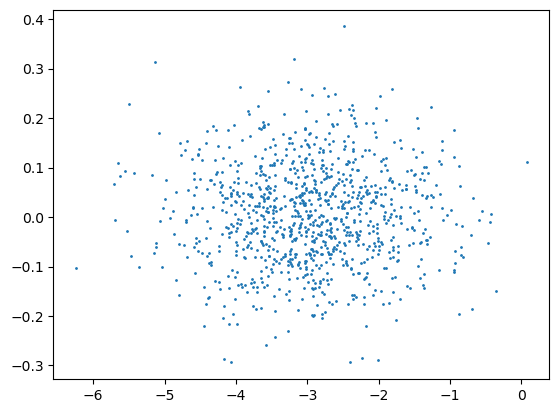

In [3]:
# plot the data
plt.scatter(X[:,0], X[:,1], s=1)

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

Mean: -0.000, Std: 1.000
Min: -3.407, Max: 3.742


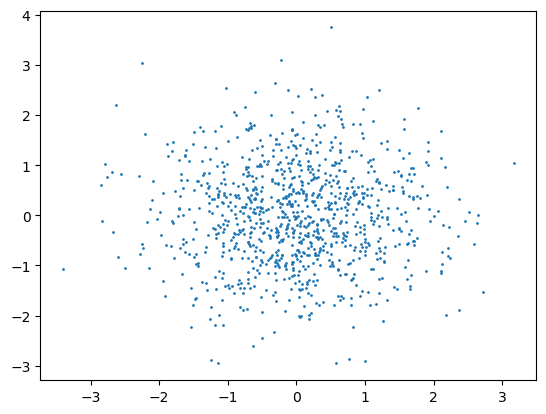

In [5]:
X_scaled = StandardScaler().fit_transform(X)
print(f"Mean: {X_scaled.mean():.3f}, Std: {X_scaled.std():.3f}")
print(f"Min: {X_scaled.min():.3f}, Max: {X_scaled.max():.3f}")
plt.scatter(X_scaled[:,0], X_scaled[:,1], s=1)
plt.show()

Mean: 0.480, Std: 0.156
Min: 0.000, Max: 1.000


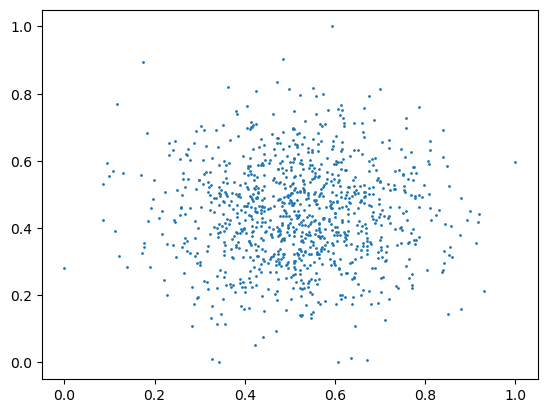

In [6]:
X_scaled = MinMaxScaler().fit_transform(X)
print(f"Mean: {X_scaled.mean():.3f}, Std: {X_scaled.std():.3f}")
print(f"Min: {X_scaled.min():.3f}, Max: {X_scaled.max():.3f}")
plt.scatter(X_scaled[:,0], X_scaled[:,1], s=1)
plt.show()

In [7]:
X = np.concatenate([X, [[10, 10]]]) # add outlier

Mean: -0.000, Std: 1.000
Min: -3.148, Max: 30.108


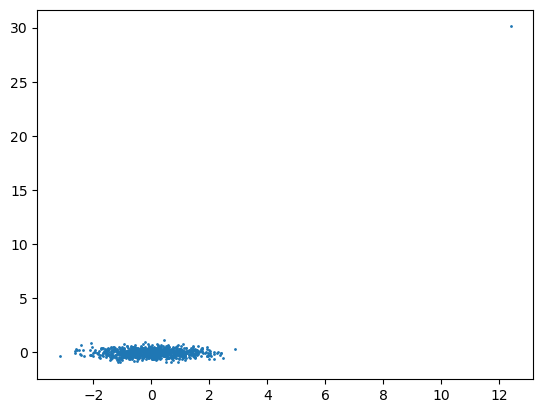

In [8]:
X_scaled = StandardScaler().fit_transform(X)
print(f"Mean: {X_scaled.mean():.3f}, Std: {X_scaled.std():.3f}")
print(f"Min: {X_scaled.min():.3f}, Max: {X_scaled.max():.3f}")
plt.scatter(X_scaled[:,0], X_scaled[:,1], s=1)
plt.show()

Mean: 0.116, Std: 0.100
Min: 0.000, Max: 1.000


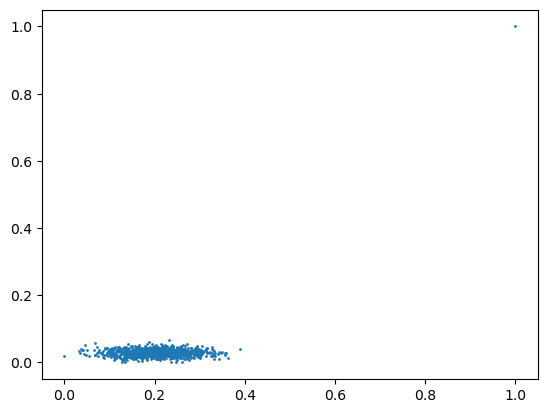

In [9]:
X_scaled = MinMaxScaler().fit_transform(X)
print(f"Mean: {X_scaled.mean():.3f}, Std: {X_scaled.std():.3f}")
print(f"Min: {X_scaled.min():.3f}, Max: {X_scaled.max():.3f}")
plt.scatter(X_scaled[:,0], X_scaled[:,1], s=1)
plt.show()

## Model Introspection

The following code plots the coefficients of a linear model.
Try to interpret the coefficients as feature importances in the following tasks.

1. Try different data splits. What do you observe?
2. Try adding and removing individual features. What do you observe?
3. Try scaling individual features. What do you observe?
4. Are the features that are considered important according to a model the only possibly important features to make predictions?

In [10]:
# imports
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# load data
data_titanic = pd.read_csv("exercise_01_titanic.csv", index_col="PassengerId")

In [12]:
def extract_features(data):
    """Extract features from existing variables"""
    
    data_extract = data.copy()
    
    # name
    name_only = data_extract["Name"].str.replace(r"\(.*\)", "", regex=True)
    first_name = name_only.str.split(", ", expand=True).iloc[:,1]
    title = first_name.str.split(".", expand=True).iloc[:,0]
    data_extract["Title"] = title
    
    # extract others (optional)
    
    return data_extract

data_extract = extract_features(data_titanic)

In [13]:
def preprocess(data):
    """Convert features into numeric variables readable by our models.""" 
    
    data_preprocessed = data.copy()
    
    # Sex
    
    data_preprocessed = pd.get_dummies(data_preprocessed, columns=["Sex"], drop_first=True)
    
    # Embarked
    
    data_preprocessed = pd.get_dummies(data_preprocessed, columns=["Embarked"], dummy_na=True)
    
    # Title
    title = data_preprocessed["Title"]
    title_counts = title.value_counts()
    higher_titles = title_counts[title_counts < 50]
    title_groups = ["higher" if t in higher_titles else t for t in title]
    data_preprocessed["Title"] = title_groups
    data_preprocessed = pd.get_dummies(data_preprocessed, columns=["Title"])
    
    # drop the rest
    data_preprocessed.drop(columns=["Name", "Cabin", "Ticket"], inplace=True)
    
    return data_preprocessed

data_preprocessed = preprocess(data_extract)

In [14]:
# before inspecting the data, selecting and building models, etc. 
# FIRST split data into train and test data (we set the test data size to 30%)

X = data_preprocessed.drop(columns="Survived")
y = data_preprocessed["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

/tmp/ipykernel_517654/3137654952.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=270)


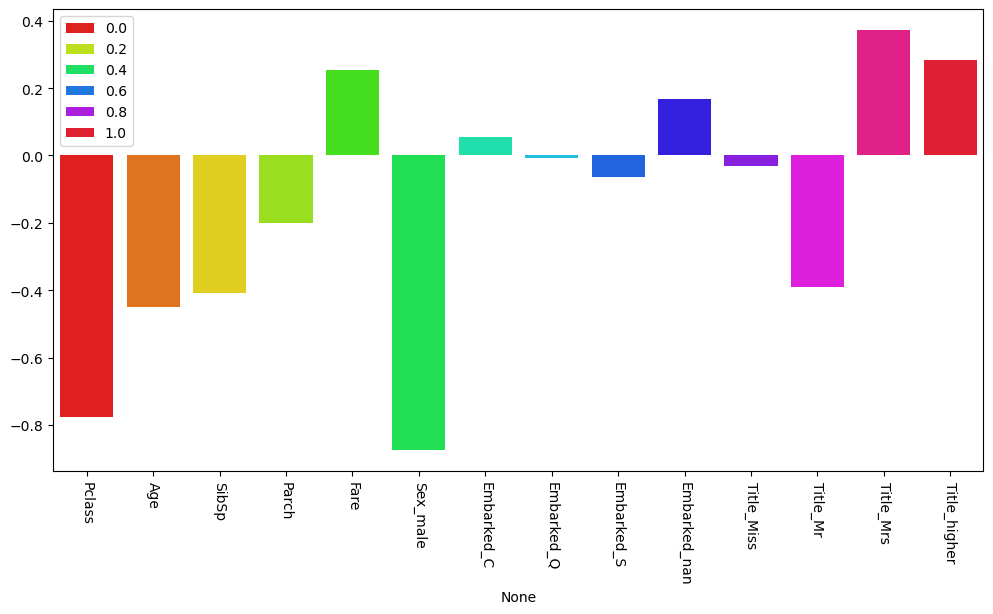

In [15]:
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()
preprocessing_pipeline = make_pipeline(scaler, imputer)


X_train_example = X_train.copy()

# TODO: drop features here
# ...

X_train_processed = preprocessing_pipeline.fit_transform(X_train_example)

# TODO: change `X_train_processed` for example here
# ...

# set model
model = LogisticRegression()

# fit for coefficient extraction
model.fit(X_train_processed, y_train)
feature_weights = model.coef_.flatten()

# plot feature importances
fig, ax = plt.subplots(1, 1, figsize=(6 * 2, 6), sharey=True)
sns.barplot(x=X_train_example.columns, y=feature_weights, ax=ax, hue=np.linspace(0, 1, len(X_train_example.columns)), palette="hsv")
ax.set_xticklabels(ax.get_xticklabels(), rotation=270)
plt.show()

## Reproducibility

1. Reproduce an experiment with these steps:
   1. Run the following code, it gives you a number.
   2. Now save the `my_data` DataFrame to a file (it is your very own dataset) and send it to your neighbour.
   3. On your neighbour's computer (with their consent), create a new notebook to read the data in a DataFrame `your_data` and run the Python line `print(int(version("pysubgroup").split(".")[2]) + np.mean(your_data["numbers"]) + np.random.random(1)[0])`.
   4. Get it to give you the same number as on your computer. (You may have to change your code and redo the previous steps to make that possible.)
2. How could a version control system have helped you here?
3. How could an environment have helped you here? (e.g. using Conda)
4. BONUS: How could Docker have helped you here?

In [ ]:
from importlib.metadata import version
import pysubgroup

rng1 = np.random.default_rng()
rng2 = np.random.default_rng()
my_data = pd.DataFrame({"numbers": rng1.random(100)})
print(int(version("pysubgroup").split(".")[2]) + np.mean(my_data["numbers"]) + rng2.random(1)[0])

7.112655896366465
